<a href="https://colab.research.google.com/github/Garaujott/Projeto_SirioLibanes_Covid_Kaggle/blob/main/ProjetoSirioLibanes_Modelagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparação do Ambiente e Observações

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Objetivos e critérios de avaliação

Como queremos prever corretamente o máximo de pessoas que precisarão ser internadas, a medida de avaliação mais importante nesse contexto é o Recall, já que essa medida nos dá dimensão de quantos positivos foram corretamente classificados. No nosso contexto, essa medida nos retorna quantos d

# Modelagem

Retomando os dados resultantes do [notebook anterior](https://github.com/Garaujott/Projeto_SirioLibanes_Covid_Kaggle/blob/main/ProjetoSirioLibanes_PreparacaoDados.ipynb), em que preparamos os dados:

([Página da base no Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19))

In [14]:
uri = 'https://github.com/Garaujott/Projeto_SirioLibanes_Covid_Kaggle/blob/main/dados/Sirio_ICU_cleaned.csv?raw=true'

covid_limpo = pd.read_csv(uri)
covid_limpo.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
4,5,0,0,0,0.0,0.0

## Removendo dados correlacionados

Antes da modelagem em si, faremos uma alteração final nos dados. Iremos criar uma função que irá excluir da modelagem variáveis que são muito correlacionadas entre si, depois aplicaremos essa função aos nossos dados e modelaremos a partir daí.

In [17]:
def remove_corr_feat(data, corr_limit = .95):
  corr_matrix = data.iloc[:, 4: -2].corr().abs()
  corr_matrix_lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape).astype('bool'), k = -1))

  feat_to_delete = [column for column in corr_matrix_lower.columns if any(corr_matrix_lower[column] > corr_limit)]
  cleaned_data = data.drop(feat_to_delete, axis = 1)
  
  return cleaned_data

In [18]:
covid_limpo_sem_corr = remove_corr_feat(covid_limpo, corr_limit = .95)

### Alternativa 1: Dummy e Regressão Logística

In [43]:
model_logit = LogisticRegression(max_iter = 2500)

### Alternativa 2: Árvore de decisão

In [37]:
model_tree = DecisionTreeClassifier()

### Alternativa 3: Modelo de Random Forest

In [22]:
model_forest = RandomForestClassifier()

## Definindo uma função básica para a modelagem

In [24]:
def run_model(model, data):
  # dividir dados
  # train-test-split
  # model.fit
  # model.predict
  # model.predict_proba
  # roc_auc_score

  x_columns = data.columns

  x = data[x_columns].drop(['ICU', 'WINDOW'], axis = 1)
  y = data['ICU']

  ## fixando a seed para possibilitar reprodutibilidade e comparação entre modelos
  SEED = 73246
  np.random.seed(SEED)

  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = .15)

  # rodando o modelo
  model.fit(x_train, y_train)
  y_predicted = model.predict(x_test)
  prob_predicted = model.predict_proba(x_test)

  # verificando AUC
  auc = roc_auc_score(y_test, prob_predicted[:,1])
  
  print(f'AUC: {auc}')
  print('\nClassification Report')
  print(classification_report(y_test, y_predicted))
  ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)

## Definindo uma função que conte com Cross-Validation

In [46]:
def run_model_cv2(model, data, n_splits, n_repeats):
  # contabilizando o tempo
  t0 = time.perf_counter()

  # garantindo reprodutibilidade
  SEED = 361728
  np.random.seed(SEED)

  # como o RepeatedStratifiedKFold não aceita 'shuffle'
  data = data.sample(frac = 1).reset_index(drop = True)

  # divisão dos dados
  x_columns = data.columns
  x = data[x_columns].drop(['ICU', 'WINDOW'], axis = 1)
  y = data['ICU']

  # cross validation -> RepeatedStratifiedKFold
  cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats) # esse cv não aceita 'shuffle'
  results = cross_validate(model, x, y, cv = cv, scoring = 'roc_auc', return_train_score =  True)

  # contabilizando o tempo
  t1 = time.perf_counter()
  t_execucao = t1 - t0

  auc_mean = np.mean(results['test_score'])
  auc_train_mean = np.mean(results['train_score'])
  auc_std = np.std(results['test_score'])

  lower_inter = auc_mean - 2 * auc_std
  upper_inter = auc_mean + 2 * auc_std

  print(f'Número de Splits (CV): {n_splits}')
  print(f'Número de Repeats (CV): {n_repeats}')
  print(f'AUC Médio (Teste): {auc_mean}')
  print(f'AUC Médio (Treino): {auc_train_mean}')
  print(f'Desvio padrão do AUC: {auc_std}')
  print(f'Tempo de execução total: {t_execucao:0.4f} segundos')
  print(f'Intervalo de Confiança 95% do AUC: [{lower_inter}, {upper_inter}]')

  print(f'AUC médio: ({auc_mean}, {auc_train_mean})') 
  #return auc_mean, auc_train_mean

## Modelando...

AUC: 0.6985714285714286

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        28
           1       0.64      0.56      0.60        25

    accuracy                           0.64        53
   macro avg       0.64      0.64      0.64        53
weighted avg       0.64      0.64      0.64        53



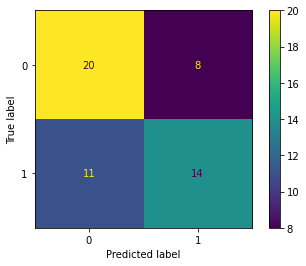

In [44]:
run_model(model_logit, covid_limpo_sem_corr)

AUC: 0.7392857142857143

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.68      0.73        28
           1       0.69      0.80      0.74        25

    accuracy                           0.74        53
   macro avg       0.74      0.74      0.74        53
weighted avg       0.74      0.74      0.74        53



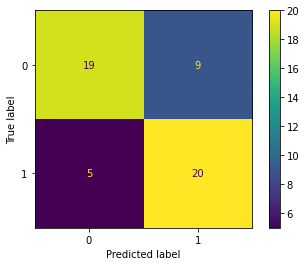

In [38]:
run_model(model_tree, covid_limpo_sem_corr)

AUC: 0.7321428571428571

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.75      0.72        28
           1       0.70      0.64      0.67        25

    accuracy                           0.70        53
   macro avg       0.70      0.70      0.70        53
weighted avg       0.70      0.70      0.70        53



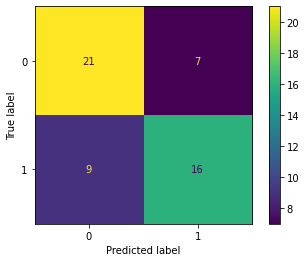

In [32]:
run_model(model_forest, covid_limpo_sem_corr)

## Aplicando validação cruzada aos modelos

In [47]:
run_model_cv2(model = model_logit, data = covid_limpo_sem_corr, n_splits = 5, n_repeats = 10)

Número de Splits (CV): 5
Número de Repeats (CV): 10
AUC Médio (Teste): 0.7611605699599119
AUC Médio (Treino): 0.8509720825120087
Desvio padrão do AUC: 0.05713352667305539
Tempo de execução total: 30.0429 segundos
Intervalo de Confiança 95% do AUC: [0.6468935166138011, 0.8754276233060226]
AUC médio: (0.7611605699599119, 0.8509720825120087)


In [48]:
run_model_cv2(model = model_tree, data = covid_limpo_sem_corr, n_splits = 5, n_repeats = 10)

Número de Splits (CV): 5
Número de Repeats (CV): 10
AUC Médio (Teste): 0.6376315924177766
AUC Médio (Treino): 1.0
Desvio padrão do AUC: 0.06444127425761342
Tempo de execução total: 0.9365 segundos
Intervalo de Confiança 95% do AUC: [0.5087490439025497, 0.7665141409330034]
AUC médio: (0.6376315924177766, 1.0)


In [49]:
run_model_cv2(model = model_forest, data = covid_limpo_sem_corr, n_splits = 5, n_repeats = 10)

Número de Splits (CV): 5
Número de Repeats (CV): 10
AUC Médio (Teste): 0.7980023654036812
AUC Médio (Treino): 1.0
Desvio padrão do AUC: 0.048457678850552924
Tempo de execução total: 11.4963 segundos
Intervalo de Confiança 95% do AUC: [0.7010870077025754, 0.894917723104787]
AUC médio: (0.7980023654036812, 1.0)
